In [1]:
!pip install gymnasium pip ale-py --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
from tqdm.auto import tqdm
from matplotlib.animation import FuncAnimation
import ale_py
import gymnasium as gym
from IPython.display import HTML
gym.register_envs(ale_py)

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.10/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.10/dist-packages/shimmy/registration.py", line 244, in _register_atari_envs
    _register_atari_configs(
  File "/usr/local/lib/python3.10/dist-packages/shimmy/registration.py", line 168, in _register_atari_configs
    from ale_py.roms import utils as rom_utils
ImportError: cannot import name 'utils' from 'ale_py.roms' (/usr/local/lib/python3.10/dist-packages/ale_py/roms/__init__.py)

  logger.warn(f"plugin: {plugin.value} raised {traceback.format_exc()}")


In [3]:
def show_frames(rgb_array, interval=100):
    rgb_array = np.stack(rgb_array)
    fig, ax = plt.subplots()
    img = ax.imshow(rgb_array[0], cmap='gray' if rgb_array.ndim==3 else None)
    plt.axis('off')
    
    def update(frame):
        img.set_data(frame)
        return img,
    
    ani = FuncAnimation(fig, update, frames=rgb_array, interval=interval, blit=True)
    display =  HTML(ani.to_jshtml())
    plt.close()
    return display

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
env = gym.make('ALE/Breakout-v5',frameskip=4)

In [5]:
state, info = env.reset()
sample_frames = [state]
for _ in range(100):
    action = env.action_space.sample()
    next_state, reward, truncated, terminated, info = env.step(action)
    sample_frames.append(next_state)
    if truncated or terminated:
        break

In [6]:
show_frames(sample_frames)

In [7]:
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84,84), interpolation=cv2.INTER_AREA)
    return frame / 255.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
state, info = env.reset()
sample_frames = [preprocess_frame(state)]
for _ in range(100):
    action = env.action_space.sample()
    next_state, reward, truncated, terminated, info = env.step(action)
    sample_frames.append(preprocess_frame(next_state))
    if truncated or terminated:
        break
show_frames(sample_frames)

In [9]:
class FrameBuffer:
    def __init__(self, frame_limit=4):
        self.frames = deque(maxlen=frame_limit)

    def preprocess(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84,84), interpolation=cv2.INTER_AREA)
        return frame / 255.

    def add(self, frame):
        frame = self.preprocess(frame)
        self.frames.append(frame)

    def get_stack(self):
        stack = np.stack(self.frames)
        return torch.from_numpy(stack).float()

    def show_stack(self):
        stack = self.get_stack()
        plt.imshow(torch.hstack([x.squeeze() for x in stack.split(1)]),cmap='gray')
        plt.axis('off')
        plt.show()
        plt.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4,32,8,4),
            nn.ReLU(),
            nn.Conv2d(32,64,4,2),
            nn.ReLU(),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136,512),
            nn.ReLU(),
            nn.Linear(512,4)
        )
    def forward(self, x):
        return self.model(x)

In [11]:
m = DQN()
m(torch.rand(1,4,84,84)).shape, sum([p.numel() for p in m.parameters()])

(torch.Size([1, 4]), 1686180)

In [12]:
class ReplayBuffer:
    def __init__(self, max_size=1_000_000, batch_size=64, device="cuda"):
        self.max_size = max_size
        self.batch_size = batch_size
        self.device = device
        self.ptr = 0
        self.size = 0

        # Preallocate memory
        self.states = np.zeros((max_size, 4, 84, 84), dtype=np.uint8)  # 4 stacked frames
        self.next_states = np.zeros((max_size, 4, 84, 84), dtype=np.uint8)
        self.actions = np.zeros((max_size,), dtype=np.int64)
        self.rewards = np.zeros((max_size,), dtype=np.float32)
        self.dones = np.zeros((max_size,), dtype=np.bool_)

    def add(self, state, action, reward, next_state, done):
        """Adds an experience to the replay buffer using a circular buffer approach."""
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self):
        """Samples a batch and moves it to GPU efficiently."""
        idxs = np.random.randint(0, self.size, size=self.batch_size)

        states = torch.from_numpy(self.states[idxs]).float().to(self.device)
        next_states = torch.from_numpy(self.next_states[idxs]).float().to(self.device)
        actions = torch.from_numpy(self.actions[idxs]).long().to(self.device)
        rewards = torch.from_numpy(self.rewards[idxs]).float().to(self.device)
        dones = torch.from_numpy(self.dones[idxs]).float().to(self.device)
    
        return {
            "state": states,
            "action":actions,
            "reward": rewards,
            "next_state": next_states,
            "done": dones
        }


    def is_ready(self):
        return self.size >= self.batch_size

    def __len__(self):
        return self.size

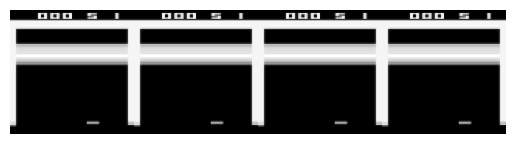

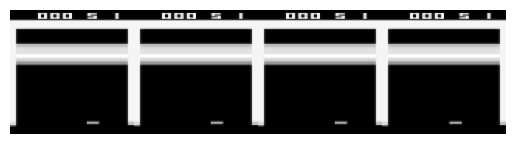

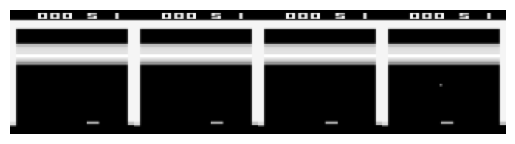

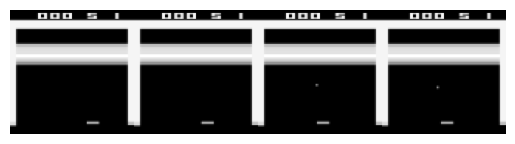

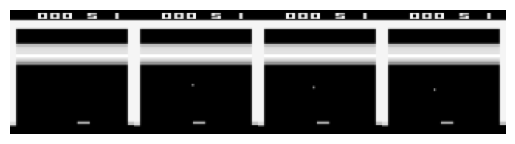

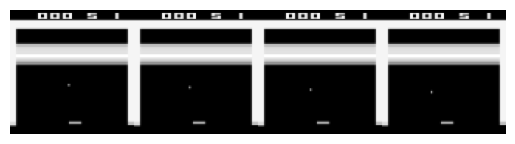

In [13]:
state, info = env.reset()
fb = FrameBuffer()
for i in range(4): fb.add(state)
fb.show_stack()
for _ in range(5):
    action = env.action_space.sample()
    next_state, reward, truncated, terminated, info = env.step(action)
    fb.add(next_state)
    fb.show_stack()
    if truncated or terminated:
        break

In [14]:
class EpsilonScheduler:
    def __init__(self, min_eps, max_eps, global_steps, exploration_frac=0.1):
        """
        Epsilon decay scheduler.

        :param min_eps: Minimum epsilon value
        :param max_eps: Maximum epsilon value
        :param global_steps: Total number of global steps for training
        :param exploration_frac: Fraction of the total steps for initial exploration
        """
        self.min_eps = min_eps
        self.max_eps = max_eps
        self.global_steps = global_steps
        self.exploration_frac = exploration_frac

        # Number of steps for exploration before decay starts
        self.exploration_steps = int(global_steps * exploration_frac)
        
    def __call__(self, global_step):
        if global_step < self.exploration_steps:
            return self.max_eps  # Exploration phase, epsilon remains high
        
        # After exploration phase, epsilon decays from max_eps to min_eps
        decay_steps = self.global_steps - self.exploration_steps
        decay_rate = (self.max_eps - self.min_eps) / decay_steps
        
        # Epsilon decay formula
        epsilon = self.max_eps - (global_step - self.exploration_steps) * decay_rate
        
        return max(self.min_eps, epsilon)  # Ensure epsilon doesn't go below min_eps

In [15]:
def make_env(seed):
    def thunk():
        env = gym.make('ALE/Breakout-v5',frameskip=4)
        env.action_space.seed(seed)
        return env
    return thunk

In [16]:
NUM_ENVS = 8

In [17]:
envs = gym.vector.SyncVectorEnv([make_env(s) for s in range(NUM_ENVS)])

In [18]:
states, infos = envs.reset()
states.shape

(8, 210, 160, 3)

In [19]:
next_states, rewards, truncateds, terminateds, infos = envs.step(envs.action_space.sample())

In [20]:
class MultiEnvFrameBuffer:
    def __init__(self, num_envs, frame_limit=4):
        self.num_envs = num_envs
        self.frames = {env_id: deque(maxlen=frame_limit) for env_id in range(self.num_envs)}

    def preprocess(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84,84), interpolation=cv2.INTER_AREA)
        return frame

    def add(self, env_frames):
        for env_id in range(self.num_envs):
            frame = self.preprocess(env_frames[env_id])
            self.frames[env_id].append(frame)

    def get_stack(self):
        stack = np.stack([np.stack(frames) for _,frames in self.frames.items()])
        return torch.from_numpy(stack).to(dtype=torch.uint8)

    def show_stack(self):
        stack = self.get_stack()
        for env_id in range(self.num_envs):
            env_stack = stack[env_id] 
            im = torch.hstack([x.squeeze() for x in env_stack.split(1)])
            # print([_.shape for _ in im])
            plt.imshow(im,cmap='gray')
            plt.axis('off')
            plt.title(f'env {env_id}')
            plt.show()
            plt.close()

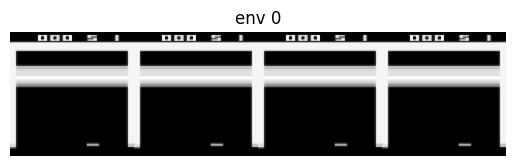

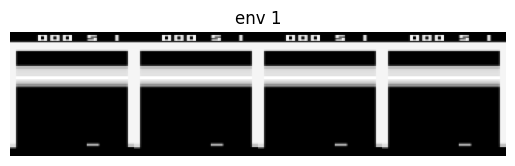

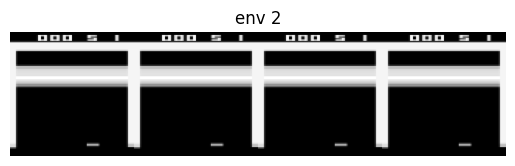

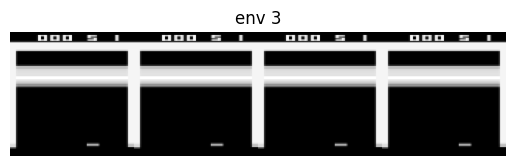

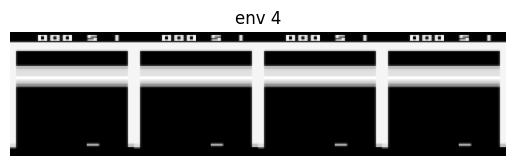

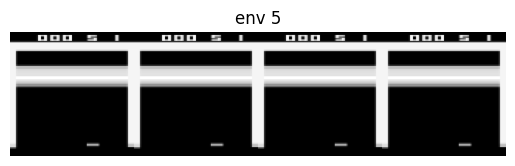

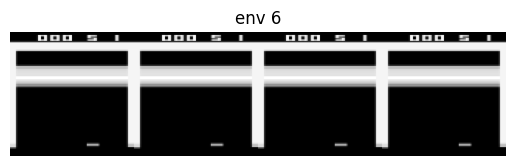

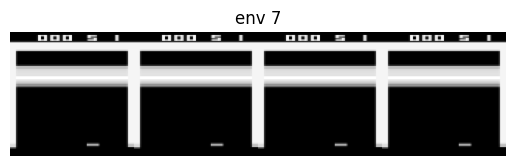

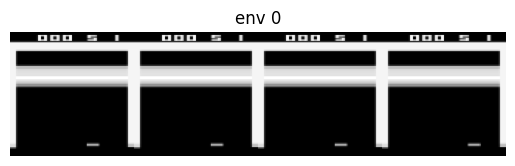

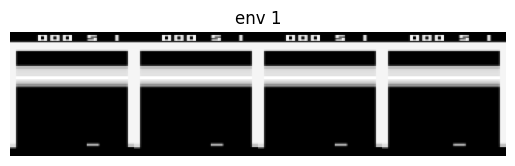

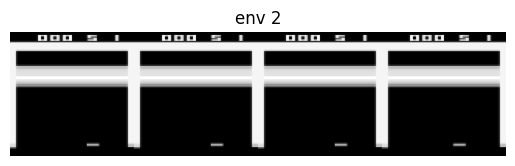

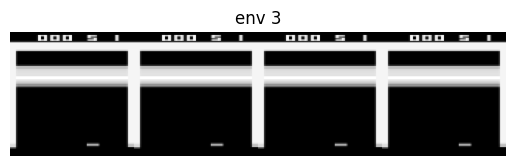

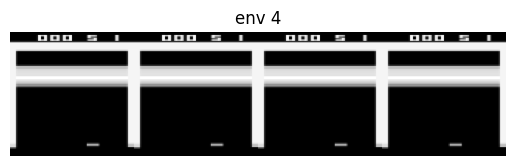

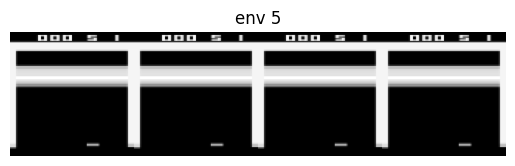

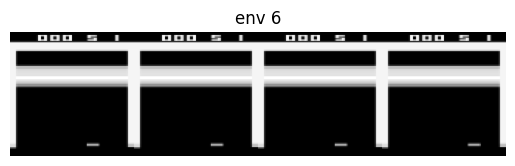

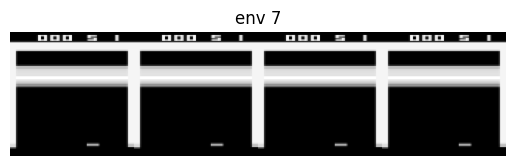

In [21]:
states, infos = envs.reset()
MEFB = MultiEnvFrameBuffer(NUM_ENVS)
for _ in range(4):
    MEFB.add(states)
MEFB.show_stack()
next_states, rewards, truncateds, terminateds, infos = envs.step(envs.action_space.sample())
MEFB.add(next_states)
MEFB.show_stack()

In [22]:
class MultiEnvReplayBuffer:
    def __init__(self, num_envs, state_shape=(4, 84, 84), max_size=1_000_000, batch_size=64, device="cuda"):
        self.num_envs = num_envs
        self.max_size = max_size
        self.batch_size = batch_size
        self.device = device
        self.ptr = 0
        self.size = 0

        # Preallocate memory with PyTorch tensors
        self.states = torch.zeros((max_size, *state_shape), dtype=torch.uint8)
        self.next_states = torch.zeros((max_size, *state_shape), dtype=torch.uint8)
        self.actions = torch.zeros((max_size,), dtype=torch.uint8)
        self.rewards = torch.zeros((max_size,), dtype=torch.float32)
        self.dones = torch.zeros((max_size,), dtype=torch.bool)

    def add(self, state, action, reward, next_state, done):
        """Adds experiences efficiently using preallocated tensors."""
        idx = np.arange(self.ptr, self.ptr + self.num_envs) % self.max_size

        self.states[idx] = state
        self.actions[idx] = torch.from_numpy(action).to(dtype=torch.uint8)
        self.rewards[idx] = torch.from_numpy(reward).float()
        self.next_states[idx] = next_state
        self.dones[idx] = torch.from_numpy(done).to(dtype=torch.bool)

        self.ptr = (self.ptr + self.num_envs) % self.max_size
        self.size = min(self.size + self.num_envs, self.max_size)

    def sample(self):
        """Samples a batch and moves it efficiently to the GPU."""
        idxs = torch.randint(0, self.size, (self.batch_size,), dtype=torch.long)

        return {
            "state": self.states[idxs].float().div_(255.).to(self.device, non_blocking=True),
            "action": self.actions[idxs].long().to(self.device, non_blocking=True),
            "reward": self.rewards[idxs].to(self.device, non_blocking=True),
            "next_state": self.next_states[idxs].float().div_(255.).to(self.device, non_blocking=True),
            "done": self.dones[idxs].float().to(self.device, non_blocking=True),
        }

    def is_ready(self):
        return self.size >= self.batch_size

    def __len__(self):
        return self.size

In [23]:
MEFB = MultiEnvFrameBuffer(NUM_ENVS)
MERB = MultiEnvReplayBuffer(NUM_ENVS,max_size=16, batch_size=2)
states, infos = envs.reset()
for _ in range(4): MEFB.add(states)
state_stack = MEFB.get_stack()
actions = envs.action_space.sample()
for _ in range(3):
    next_states, rewards, terminateds, truncateds, infos = envs.step(actions)
    MEFB.add(next_states)
    next_state_stack = MEFB.get_stack()
    dones = np.logical_or.reduce([terminateds,truncateds])
    MERB.add(state_stack, actions, rewards, next_state_stack, dones)
MERB.ptr, MERB.size

(8, 16)

In [24]:
batch = MERB.sample()

In [25]:
batch['state'].shape

torch.Size([2, 4, 84, 84])

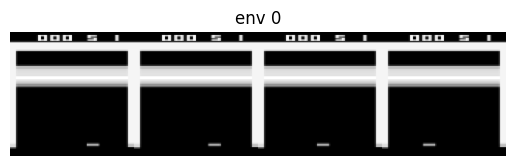

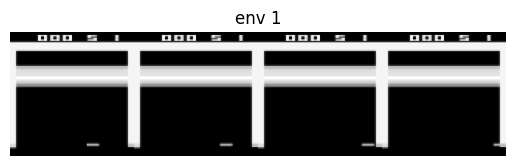

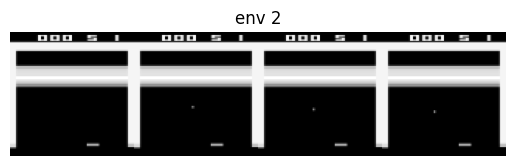

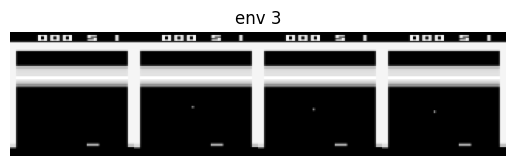

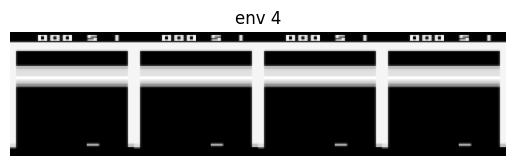

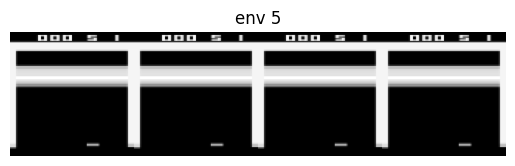

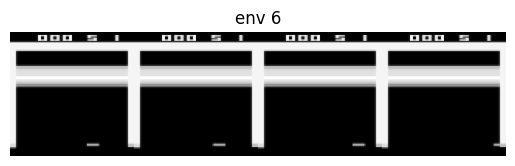

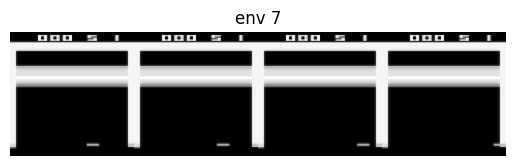

In [26]:
MEFB.show_stack()

In [27]:
del MERB, MEFB, envs, batch
import gc
gc.collect()
torch.cuda.empty_cache()

In [28]:
def epsilon_greedy(q_online, envs, state, eps, device):
    if eps > np.random.uniform():
        return envs.action_space.sample()
    else:
        with torch.no_grad():
            state = state.float().div_(255.).to(device)
            q_values = q_online(state)
            predicted_actions = q_values.argmax(dim=1).cpu().numpy()
            return predicted_actions

In [29]:
def sync_weights(q_online, q_target):
    online_sd = q_online.state_dict()
    q_target.load_state_dict(online_sd)
    return q_online, q_target

In [30]:
NUM_GLOBAL_STEPS = 500_000
TRAINING_START_STEP = 40_000

BUFFER_SIZE = 500_000
BATCH_SIZE = 128

UPDATE_FREQ = 1000

EPS_MAX = 1.0
EPS_MIN = 0.01
EXPLORATION_FRAC = 0.2

discount_rate = 0.99

In [31]:
eps_scheduler = EpsilonScheduler(min_eps=EPS_MIN, max_eps=EPS_MAX, global_steps=NUM_GLOBAL_STEPS, exploration_frac=EXPLORATION_FRAC)

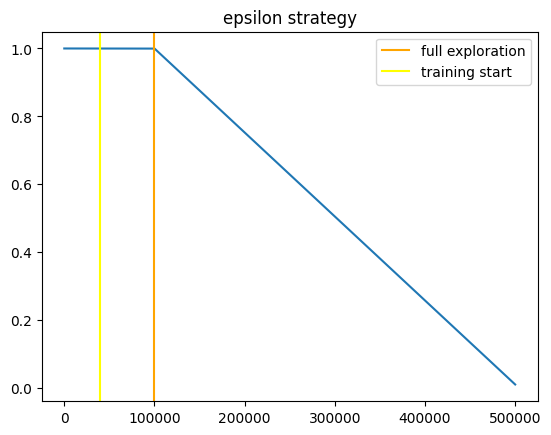

In [32]:
eps_values = [eps_scheduler(i) for i in range(NUM_GLOBAL_STEPS)]
plt.plot(eps_values)
plt.axvline(int(NUM_GLOBAL_STEPS*EXPLORATION_FRAC),label='full exploration',color='orange')
plt.axvline(TRAINING_START_STEP,label='training start',color='yellow')
plt.legend()
plt.title('epsilon strategy')
plt.show()

In [33]:
NUM_ENVS = 8

envs = gym.vector.SyncVectorEnv([make_env(s) for s in range(NUM_ENVS)])
frame_buffer = MultiEnvFrameBuffer(NUM_ENVS)
replay_buffer = MultiEnvReplayBuffer(NUM_ENVS, max_size=BUFFER_SIZE, batch_size=BATCH_SIZE)


episode_rewards = []
episode_losses = []

device = 'cuda'

q_online = DQN().to(device)
q_target = DQN().to(device)
optim = torch.optim.Adam(q_online.parameters(), lr=1e-4)

q_online, q_target = sync_weights(q_online, q_target)


done = False
episode_loss = 0.
episode_reward = 0.
episode_step = 0
num_episodes = 0
training = False

prog_bar = tqdm(range(NUM_GLOBAL_STEPS))
for global_step in prog_bar:

    if done or global_step == 0:
        states, _ = envs.reset()
        
        for _ in range(4):
            frame_buffer.add(states)
            
        if global_step > 0:
            episode_losses.append(episode_loss / episode_step)
            episode_rewards.append(episode_reward)
            episode_loss, episode_reward, episode_step = 0,0,0

        num_episodes += 1
        done = False

    eps = eps_scheduler(global_step)

    current_stack = frame_buffer.get_stack()
    actions = epsilon_greedy(q_online, envs, current_stack, eps, device)

    next_states, rewards, terminateds, truncateds, infos = envs.step(actions)
    frame_buffer.add(next_states)

    next_stack = frame_buffer.get_stack()
    dones = np.logical_or(terminateds,truncateds)
    
    # state, action, reward, next_state, done
    replay_buffer.add(current_stack, actions, rewards, next_stack, dones)

    episode_step += 1
    episode_reward += np.mean(rewards)

    done = np.any(terminateds) or np.any(truncateds)

    if replay_buffer.is_ready() and global_step >= TRAINING_START_STEP:
        training = True
        batch = replay_buffer.sample()
        states = batch['state']
        actions = batch['action']
        rewards = batch['reward']
        next_states = batch['next_state']
        dones = batch['done']

        predicted_q_values = q_online(states).gather(1, actions.unsqueeze(1)).flatten()

        best_actions_online = q_online(next_states).argmax(dim=1)
        next_q_values = q_target(next_states).gather(1, best_actions_online.unsqueeze(1)).flatten()

        target_q_values = rewards + discount_rate * (1-dones) * next_q_values

        loss = F.smooth_l1_loss(predicted_q_values, target_q_values)
        loss.backward()
        optim.step()
        optim.zero_grad()

        episode_loss += loss.item()

    if global_step % UPDATE_FREQ == 0:
        q_online, q_target = sync_weights(q_online, q_target)

    prog_bar.set_description(f"{training=} {num_episodes=} | loss: {(episode_loss/episode_step):.3f} | reward: {episode_reward} | buffer: {len(replay_buffer)} | eps: {eps:.3f}")

  0%|          | 0/500000 [00:00<?, ?it/s]

In [34]:
envs.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


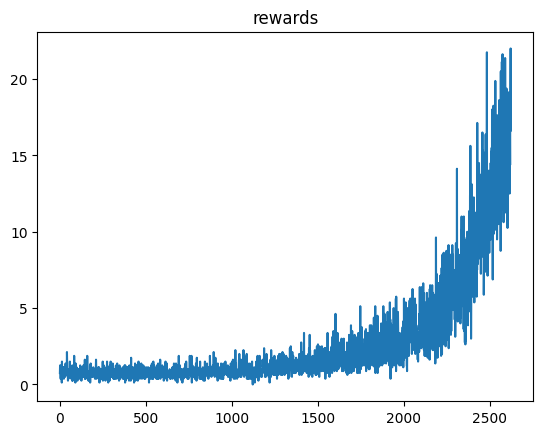

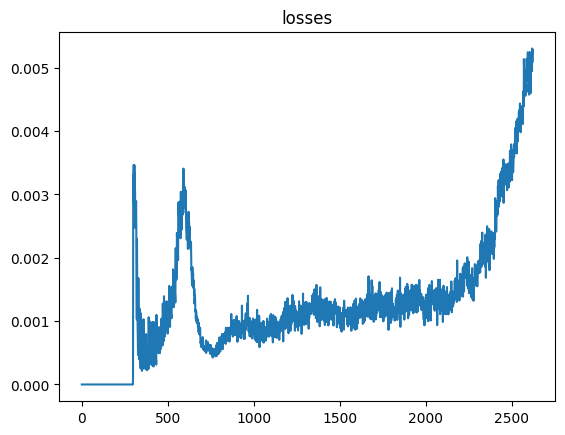

In [35]:
plt.plot(episode_rewards)
plt.title('rewards')
plt.show()
plt.plot(episode_losses)
plt.title('losses')
plt.show()

In [36]:
torch.save(q_online.state_dict(), 'breakout.pt')

In [37]:
eval_env = gym.make('ALE/Breakout-v5',frameskip=4)
frame_buffer = FrameBuffer()
state, info = eval_env.reset()
for _ in range(4): frame_buffer.add(state)
results = [state,]
q_online.eval()
while True:
    with torch.no_grad():
        state = frame_buffer.get_stack()
        action = q_online(state.cuda().unsqueeze(0)).argmax(dim=1).cpu().flatten().item()
    next_state, reward, terminated, truncated, info = env.step(action)
    results.append(next_state)
    frame_buffer.add(next_state)
    if terminated or truncated:
        break

In [ ]:
show_frames(results)